```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. see different plots: https://scikit-plot.readthedocs.io/en/stable/metrics.html
2. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432
3. https://dl.acm.org/doi/10.1145/1143844.1143874
4. https://dl.acm.org/doi/10.1145/65943.65945
5. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/
6. (free): http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf
7. https://developers.google.com/machine-learning/crash-course/classification/thresholding
```

# Classification Metrics and Evaluation

## Table of Contents

- [Confusion Matrix](#matrix)
- [Classification Metrics](#metrics)
- [Classification Report](#report)
- [Diagnostic tools for probabilistic forecast in binary classification](#prob)
    - [ROC Curve and AUC (best for balanced classes)](#roc)
    - [Precision-Recall Curve (best for imbalanced classes)](#prc)
    - [PROBLEM: Compare ROC Curve and PR Curve for Imbalanced Classes](#imbalanced)
    - [Cumulative Gains Plot](#gain)
    - [Lift Curve](#lift)
- [Class Balance](#class)
- [Class Prediction Error](#class_err)
- [Discrimination Threshold](#threshold)
    - [Threshold-Moving for Imbalanced Classification](#threshold_imb)
    - [Discrimination Thershold Plot](#threshold_plot)
    - [Optimal Threshold for ROC Curve](#threshold_roc)
    - [Optimal Threshold for Precision-Recall Curve](#threshold_prc)
    - [Optimal Threshold Tuning](#threshold_tune)
- [Optimal Threshold for Precision-Recall Curve](#threshold_prc)
- [Optimal Threshold for Precision-Recall Curve](#threshold_prc)
- [Optimal Threshold for Precision-Recall Curve](#threshold_prc)
- [Optimal Threshold for Precision-Recall Curve](#threshold_prc)





In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# To eliminate Yellowbrick warming: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import matplotlib.font_manager

import seaborn as sns

In [104]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df = get_dataset('pima-indians-diabetes')
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Missing values?
df.isnull().mean().value_counts()

0.0    9
dtype: int64

In [6]:
y = df[['class']]
X = df.drop(columns=['class'])

In [7]:
# Are the classes balanced
y.value_counts()

class
0        500
1        268
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1, max_depth=None)
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [11]:
y_predict = rfc.predict(X_test)
y_predict.shape

(231,)

In [12]:
y_predict = y_predict.reshape(y_predict.shape[0], 1)
y_predict.shape

(231, 1)

---
<a id='matrix'></a>

## Confusion Matrix
A **confusion matrix** can aid in understanding how a classifier performs.

A **binary classifier** can have four classification results: `true positives (TP)`, `true negatives (TN)`, `false positives (FP)`, and `false negatives (FN)`. The first two are correct classifications.

Here is a common example for remembering the other results. Assuming positive means pregnant and negative is not pregnant, a `false positive` is like claiming a man is pregnant. A `false negative` is claiming that a pregnant woman is not (when she is clearly showing). These last two types of errors are referred to as `type 1` and `type 2` errors, respectively.

<img src="images/type1_type2_errors.png" alt="" style="width: 650px;"/>

Another way to remember these is that `P (for false positive)` has one straight line in it (`type 1 error`), and `N (for false negative)` has two vertical lines in it (`type 2 error`).

In [13]:
tp = ((y_test == 1) & (y_test == y_predict)).sum().values[0]
tn = ((y_test == 0) & (y_test == y_predict)).sum().values[0]
fp = ((y_test == 0) & (y_test != y_predict)).sum().values[0]
fn = ((y_test == 1) & (y_test != y_predict)).sum().values[0]

In [14]:
f'tp = {tp}, tn = {tn}, fp = {fp}, fn = {fn}'

'tp = 46, tn = 131, fp = 19, fn = 35'

Well-behaving classifiers ideally have high counts in the true diagonal. We can create a DataFrame using the sklearn `confusion_matrix` function.

In [15]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=[
        "Predicted 0",
        "Predicted 1",
    ],
    index=["True 0 (Healthy)", "True 1 (Diabetes)"],
)

,Predicted 0,Predicted 1
True 0 (Healthy),131,19
True 1 (Diabetes),35,46


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not 

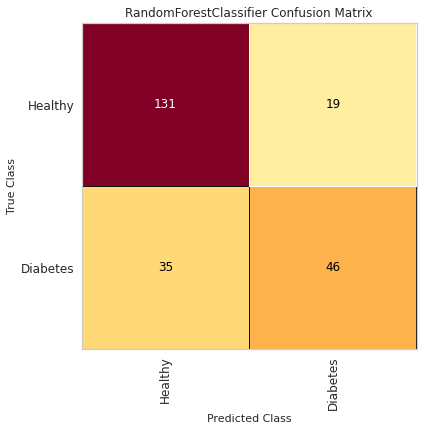

In [16]:
from yellowbrick.classifier import (
    ConfusionMatrix,
)

mapping = {0: "Healthy", 1: "Diabetes"}

fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rfc,
    classes=["Healthy", "Diabetes"],
    label_encoder=mapping,
)

cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig("images/confusion_matrx.png", dpi=300)

**Confusion matrix:** The upper left and lower right are correct classifications. The lower left is false negative. The upper right is false positive.

---
<a id='metrics'></a>

## Metrics
The [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) module includes metrics to evaluate classification models. **Metric functions ending in `loss` or `error` should be minimized. Functions ending in `score` should be maximized.**

In [17]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

The `sklearn.metrics` module implements many **common classification metrics**, including:
- **accuracy:** Percent of correct predictions
- **average_precision:** Precision recall curve summary
- **f1:** Harmonic mean of precision and recall
- **neg_log_loss:** Logistic or cross-entropy loss (model must support `predict_proba`)
- **precision:** Ability to find only relevant samples (not label a negative as a positive)
- **recall:** Ability to find all positive samples
- **roc_auc:** Area under the receiver operator characteristic curve

f1, precision, and recall all support the following suffixes for `multiclass classifers`:
- **_micro:** Global weighted average of metric
- **_macro:** Unweighted average of metric
- **_weighted:** Multiclass weighted average of metric
- **_samples:** Per sample metric

These strings can be used as the `scoring` parameter when doing grid search, or you can use functions from the `sklearn.metrics` module that have the same names as the strings but end in `_score`. See the following note for examples.

### Accuracy
**Accuracy** is the percentage of correct classifications. What is good accuracy? It depends. If I’m predicting fraud (which usually is a rare event, say 1 in 10,000), I can get very high accuracy by always predicting not fraud. But this model is not very useful. Looking at other metrics and the cost of predicting a false positive and a false negative can help us determine if a model is decent. See also `balanced accuracy` (below) for imbalanced classes.

In [18]:
(tp + tn) / (tp + tn + fp + fn)

0.7662337662337663

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.7662337662337663

<img src="images/precision_recall.png" alt="" />

- **precision:** Ability to find only relevant samples (not label a negative as a positive)
- **recall:** Ability to find all positive samples

From: https://en.wikipedia.org/wiki/F1_score

### Recall
**Recall** (also called `sensitivity` or `True Positive Rate`) is the percentage of positive values correctly classified. It is ability to find all positive samples. **Find everything you need**. `How many relevant items are selected?`

It describes how good the model is at predicting the positive class when the actual outcome is positive.

In [23]:
# Recall, Hit rate, Sensitivity, True Positive Rate
TPR = tp / (tp + fn)
TPR

0.5679012345679012

In [24]:
from sklearn.metrics import recall_score

recall_score(y_test, y_predict)

0.5679012345679012

### Precision
**Precision** is the percent of positive predictions that were correct. It is ability to find only relevant samples (not label a negative as a positive). **Limit junk level**. `How many selected items are relevant?`

It describes how good a model is at predicting the positive class.

In [25]:
# Precision, Positive Predictive Value
PPV = tp / (tp + fp)
PPV

0.7076923076923077

In [26]:
from sklearn.metrics import precision_score

precision_score(y_test, y_predict)

0.7076923076923077

### Specificity

<img src="images/sensitivity_and_specificity.png" alt="" />

From: https://en.wikipedia.org/wiki/Sensitivity_and_specificity

In [45]:
# Selectivity, Specificity, True Negative Rate
TNR = tn / (tn + fp)
TNR

0.8733333333333333

### False Positive Rate
In statistics, when performing multiple comparisons, a `false positive ratio` (also known as `fall-out` or `false alarm ratio`) is the probability of falsely rejecting the null hypothesis for a particular test. 

It summarizes how often a positive class is predicted when the actual outcome is negative. 

From: https://en.wikipedia.org/wiki/False_positive_rate

In [40]:
# False Positive Rate
FPR = fp / (tn + fp)
FPR

0.12666666666666668

### Negative Predictive Value

From: https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values

In [28]:
# Negative Predictive Value
NPV = tn / (tn + fn)
NPV

0.7891566265060241

### Balanced Accuracy
From: https://en.wikipedia.org/wiki/Precision_and_recall

In [29]:
# Balanced Accuracy
BA = (TPR + TNR) / 2
BA

0.7206172839506173

### F1 Score / Metric
**F1** is the harmonic mean of recall and precision.

In [22]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)

0.6459627329192547

In [23]:
from sklearn.metrics import f1_score

f1_score(y_test, y_predict)

0.6459627329192547

### F beta Score / Metric
Two other commonly used **F measures** are the **F2 measure**, which weights recall higher than precision, and the **F0.5 measure**, which puts more emphasis on precision than recall.

From: https://en.wikipedia.org/wiki/Precision_and_recall

In [33]:
# F2 Score -> More on Recall
beta_sqared = 2**2
F2 = (1 + beta_sqared) * PPV * TPR / ((beta_sqared * PPV) + TPR) 
F2

0.5912596401028278

In [34]:
# F0.5 Score -> More on Precision
beta_sqared = 0.5**2
F05 = (1 + beta_sqared) * PPV * TPR / ((beta_sqared * PPV) + TPR) 
F05

0.6744868035190617

---
<a id='report'></a>

## Classification Report
Yellowbrick has a **classification report** showing `precision`, `recall`, and `f1` scores for both positive and negative values.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


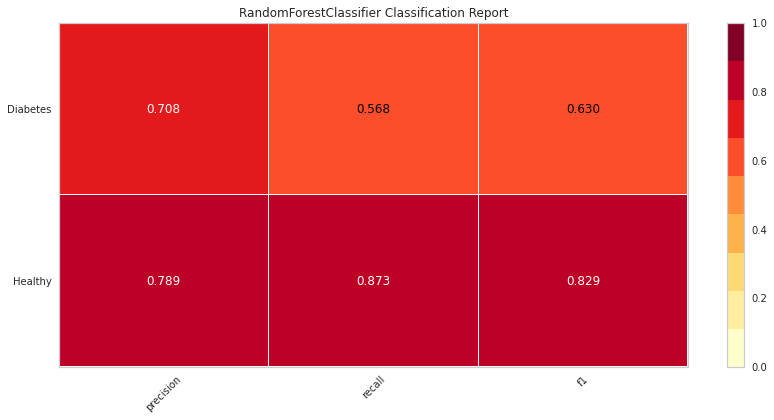

In [35]:
from yellowbrick.classifier import (
    ClassificationReport,
)

fig, ax = plt.subplots(figsize=(12, 6))
cm_viz = ClassificationReport(
    rfc,
    classes=["Healthy", "Diabetes"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig("images/classification_report.png", dpi=300)

---
<a id='prob'></a>

## Diagnostic tools for probabilistic forecast in binary classification 

In a classification problem, we may decide to `predict the class values directly`. Alternately, it can be more flexible to `predict the probabilities for each class` instead. The reason for this is to provide the capability to choose and even calibrate the threshold for how to interpret the predicted probabilities.

For example, a default might be to use a threshold of 0.5, meaning that a probability in [0.0, 0.49] is a negative outcome (0) and a probability in [0.5, 1.0] is a positive outcome (1). This threshold can be adjusted to tune the behavior of the model for a specific problem. An example would be `to reduce more of one or another type of error`.

When making a prediction for a binary or two-class classification problem, there are two types of errors that we could make.

- **Type 1 Error: False Positive.** Predict an event when there was no event.
- **Type 2 Error: False Negative.** Predict no event when in fact there was an event.

`By predicting probabilities and calibrating a threshold, a balance of these two concerns can be chosen` by the operator of the model.

For example, in a smog prediction system, we may be far more concerned with having low false negatives than low false positives. A false negative would mean not warning about a smog day when in fact it is a high smog day, leading to health issues in the public that are unable to take precautions. A false positive means the public would take precautionary measures when they didn’t need to.

Two diagnostic tools that help in the interpretation of probabilistic forecast for binary (two-class) classification predictive modeling problems are **ROC Curves** and **Precision-Recall Curves**.

- **ROC Curves** summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds. ROC curves should be used when there are roughly equal numbers of observations for each class. The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance. Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill. The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.
- **Precision-Recall Curves** summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. Precision-Recall curves should be used when there is a moderate to large class imbalance.

`ROC Curves are appropriate when the observations are balanced between each class, whereas Precision-Recall Curves are appropriate for imbalanced datasets`.

---
<a id='roc'></a>

## ROC Curve and AUC (best for balanced classes)
A **[Receiver Operating Characteristic (ROC) Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)** illustrates how the classifier performs by tracking the true positive rate (`TPR`, recall, sensitivity) as the false positive rate (`FPR`, inverted specificity) changes. It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

A rule of thumb is that the plot should bulge out toward the top-left corner. A plot that is to the left and above another plot indicates better performance. The diagonal in this plot indicates the behavior of a random guessing classifier. By taking the **Area Under the Curve (AUC)**, you get a metric for evaluating the performance.

The ROC curve is a useful tool for a few reasons:

- The curves of different models can be compared directly in general or for different thresholds.
- The **Area Under the Curve (AUC)** can be used as a summary of the model skill.
- The shape of the curve contains a lot of information, including what we might care about most for a problem, the expected false positive rate, and the false negative rate.

To make this clear:

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

If you are confused, remember, when we predict a binary outcome, it is either a correct prediction (true positive) or not (false positive). There is a tension between these options, the same with true negative and false negative.

A `skilful model` will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. This is what we mean when we say that the model has skill. Generally, `skilful models are represented by curves that bow up to the top left of the plot`.

A `no-skill classifier` is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A model with no skill is represented at the point (0.5, 0.5). `A model with no skill at each threshold is represented by a diagonal line from the bottom left of the plot to the top right and has an AUC of 0.5`.

`A model with perfect skill is represented at a point (0,1)`. A model with perfect skill is represented by a line that travels from the bottom left of the plot to the top left and then across the top to the top right.

An operator may plot the ROC curve for the final model and choose a threshold that gives a desirable balance between the false positives and false negatives.

**Below** there is an exacmple on how ROC Curve can be deceptive when using for imballanced classification problem.

In [38]:
y_test.head()

,class
730,1
198,1
24,1
417,1
387,1


In [54]:
y_test.values.ravel()

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [39]:
y_predict[:5]

array([[0],
       [0],
       [1],
       [1],
       [1]])

We can plot a **ROC Curve** for a model in Python using the [roc_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) scikit-learn function. The function takes both the true outcomes (0,1) from the test set and the predicted probabilities for the 1 class. The function returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.

In [47]:
# Calculate probabilities for both classes
y_predict_proba = rfc.predict_proba(X_test)
y_predict_proba.shape

(231, 2)

In [56]:
y_predict_proba[:5]

array([[0.847, 0.153],
       [0.634, 0.366],
       [0.198, 0.802],
       [0.456, 0.544],
       [0.475, 0.525]])

In [61]:
# Keep probabilities for the positive outcome only (Class 1)
y_predict_proba_class_1 = y_predict_proba[:, 1]
y_predict_proba_class_1[:5]

array([0.153, 0.366, 0.802, 0.544, 0.525])

In [62]:
from sklearn.metrics import roc_curve

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_predict_proba_class_1)

In [64]:
fpr[:5]

array([0.        , 0.        , 0.        , 0.00666667, 0.00666667])

In [65]:
tpr[:5]

array([0.        , 0.01234568, 0.17283951, 0.17283951, 0.19753086])

In [66]:
thresholds

array([1.894, 0.894, 0.762, 0.761, 0.754, 0.753, 0.747, 0.744, 0.743,
       0.725, 0.704, 0.695, 0.685, 0.681, 0.664, 0.647, 0.623, 0.622,
       0.608, 0.6  , 0.597, 0.593, 0.561, 0.56 , 0.556, 0.544, 0.542,
       0.539, 0.537, 0.52 , 0.514, 0.49 , 0.466, 0.465, 0.453, 0.448,
       0.437, 0.405, 0.401, 0.397, 0.394, 0.38 , 0.372, 0.366, 0.354,
       0.353, 0.343, 0.341, 0.34 , 0.339, 0.338, 0.33 , 0.329, 0.32 ,
       0.319, 0.316, 0.313, 0.312, 0.292, 0.291, 0.29 , 0.272, 0.261,
       0.257, 0.253, 0.251, 0.203, 0.198, 0.191, 0.19 , 0.182, 0.18 ,
       0.172, 0.153, 0.148, 0.141, 0.134, 0.115, 0.113, 0.109, 0.106,
       0.101, 0.098, 0.097, 0.093, 0.09 , 0.089, 0.062, 0.061, 0.06 ,
       0.058, 0.041, 0.039, 0.033, 0.031, 0.026, 0.022, 0.021, 0.019,
       0.014, 0.013, 0.003])

The **AUC for the ROC** can be calculated using the [roc_auc_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) function. Like the `roc_curve()` function, the AUC function takes both the true outcomes (0,1) from the test set and the predicted probabilities for the 1 class. It returns the AUC score between 0.0 and 1.0 for no skill and perfect skill respectively.

In [67]:
# Calculate AUC
auc = roc_auc_score(y_test.values.ravel(), y_predict_proba_class_1)
print('AUC: %.3f' % auc)

AUC: 0.824


In [79]:
# generate a no skill prediction data (majority class) data (for the plot)
# always predicts 0
no_skill_proba_class_1 = [0 for _ in range(len(y_test.values.ravel()))]
no_skill_auc = roc_auc_score(y_test.values.ravel(), no_skill_proba_class_1)
print('AUC: %.3f' % no_skill_auc)

# Calculate roc curve
no_skill_fpr, no_skill_tpr, no_skill_thresholds = roc_curve(y_test.values.ravel(), no_skill_proba_class_1)

AUC: 0.500


In [80]:
no_skill_fpr[:5], no_skill_tpr[:5]

(array([0., 1.]), array([0., 1.]))

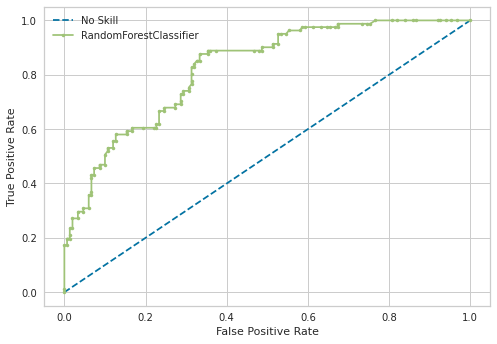

In [82]:
# plot the roc curve for the model
pyplot.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='RandomForestClassifier')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

Given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision if not using `random_state`, the results may vary. **Consider running the example a few times and compare the average outcome**.

#### ROC Curve Example
A complete example of calculating the ROC curve and ROC AUC for a Logistic Regression model on a small test problem is listed below.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


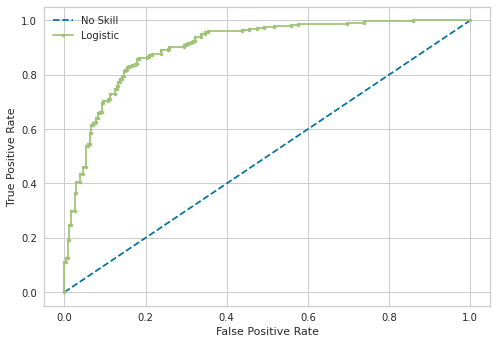

In [75]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# generate a no skill prediction (majority class)
# always predicts 0
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

### ROCAUC with Yellowbrick

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


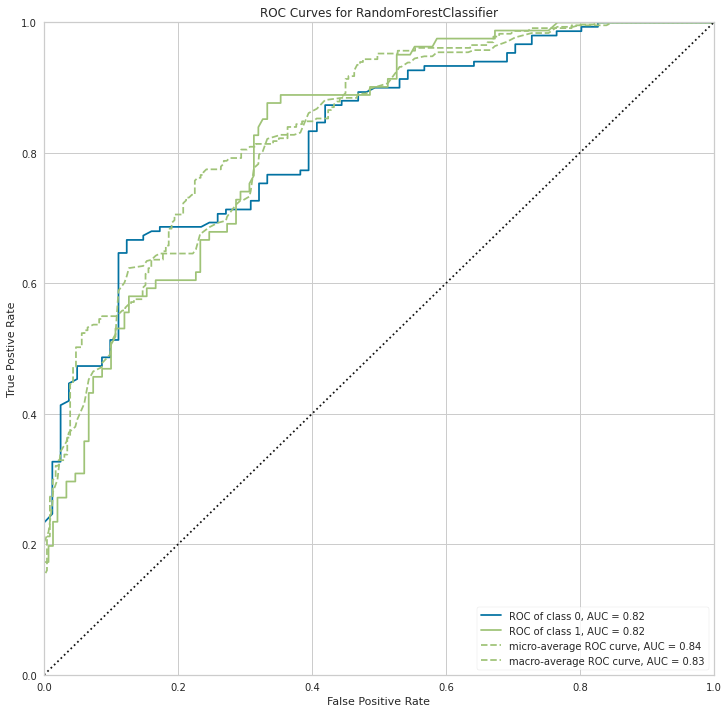

In [84]:
from yellowbrick.classifier import ROCAUC

fig, ax = plt.subplots(figsize=(12, 12))
roc_viz = ROCAUC(rfc)
roc_viz.score(X_test, y_test)

roc_viz.poof()
fig.savefig("images/roc.png", dpi=300)

---
<a id='prc'></a>

## Precision-Recall Curve (best for imbalanced classes)
`The ROC curve may be overly optimistic for imbalanced classes`. Another option for evaluating classifiers is using a **Precision-Recall (PR) Curve**. Classification is a balancing act of finding everything you need (`recall`) while limiting the junk results (`precision`). This is typically a trade-off. As recall goes up, precision usually goes down and vice versa.

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1). The reason for this is that typically **the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives**.

**Key to the calculation of `precision` and `recall` is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1**.

A `precision-recall curve` is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the `ROC curve`.

A no-skill classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. The no-skill line changes based on the distribution of the positive to negative classes. It is a `horizontal line` with the value of the ratio of positive cases in the dataset. For a balanced dataset, this is 0.5.

`A model with perfect skill is depicted as a point at (1,1)`. A skilful model is represented by a curve that bows towards (1,1) above the flat line of no skill.

There are also composite scores that attempt to summarize the precision and recall; two examples include:

- **F-Measure or F1 score:** that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are rates).
- **Area Under Curve:** like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F-Measure summarizes model skill for a specific probability threshold (e.g. 0.5), whereas the area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures **useful tools for binary classification problems that have an imbalance in the observations for each class**.

Precision and recall can be calculated in `scikit-learn`. The precision and recall can be calculated for thresholds using the [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function that takes the true output values and the probabilities for the positive class as output and returns the precision, recall and threshold values. The F-Measure can be calculated by calling the [f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) function that takes the true class values and the predicted class values as arguments.

In [86]:
from sklearn.metrics import precision_recall_curve

# Calculate roc curve
precision, recall, thresholds = precision_recall_curve(y_test.values.ravel(), y_predict_proba_class_1)

In [90]:
precision[:5], recall[:5], thresholds[:5]

(array([0.41326531, 0.41450777, 0.41666667, 0.42105263, 0.42328042]),
 array([1.        , 0.98765432, 0.98765432, 0.98765432, 0.98765432]),
 array([0.058, 0.06 , 0.061, 0.062, 0.064]))

In [92]:
len(precision), len(recall), len(thresholds)

(174, 174, 173)

In [98]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1_score = f1_score(testy, yhat)

The area under the precision-recall curve can be approximated by calling the [auc()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) function and passing it the recall (x) and precision (y) values calculated for each threshold.

In [97]:
from sklearn.metrics import auc

# Calculate precision-recall AUC
auc_score = auc(recall, precision)
auc_score

0.7270489649017478

When plotting precision and recall for each threshold as a curve, it is important that `recall is provided as the x-axi`s and `precision is provided as the y-axis`.

Logistic: f1=0.841 auc=0.727


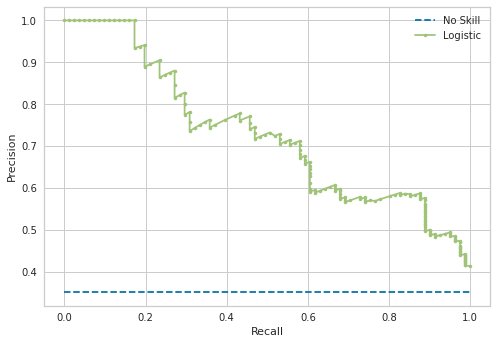

In [101]:
# Summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (f1_score, auc_score))

# Plot the precision-recall curves
no_skill = len(y_test.values.ravel()[y_test.values.ravel()==1]) / len(y_test.values.ravel())
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')

# Axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

# Show the legend
pyplot.legend()

# Show the plot
pyplot.show()

Given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision if not using `random_state`, the results may vary. **Consider running the example a few times and compare the average outcome**.

#### Precision-Recall Curve Example
The complete example of calculating precision-recall curves for a Logistic Regression model is listed below. The precision-recall curve plot is then created showing the precision/recall for each threshold for a logistic regression model (orange) compared to a no skill model (blue).

Logistic: f1=0.841 auc=0.898


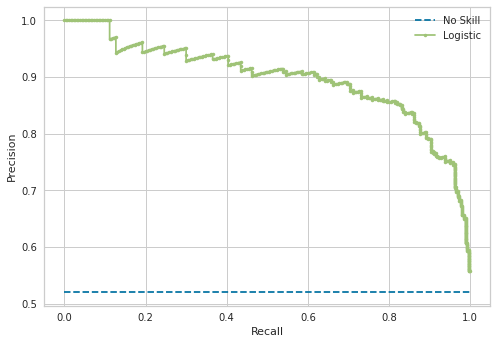

In [85]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

### PrecisionRecallCurve with Yellowbrick

In [43]:
from sklearn.metrics import (
    average_precision_score,
)

average_precision_score(y_test, y_predict)

0.5534144867478201

0.7124958410011633


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/base.py:359: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y, **kwargs)


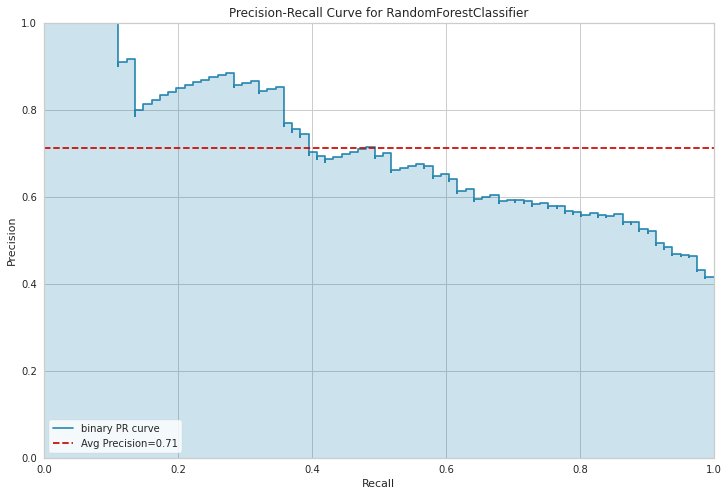

In [44]:
from yellowbrick.classifier import (
    PrecisionRecallCurve,
)

fig, ax = plt.subplots(figsize=(12, 8))
viz = PrecisionRecallCurve(
    RandomForestClassifier(max_depth=3)
)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()
fig.savefig("images/precision_recall_curve.png", dpi=300)

---
<a id='imbalanced'></a>

### PROBLEM: Compare ROC Curve and PR Curve for Imbalanced Classes
Below is the same **ROC Curve** example with a modified problem where there is a ratio of about 100:1 ratio of class=0 to class=1 observations (specifically Class0=985, Class1=15).

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.716


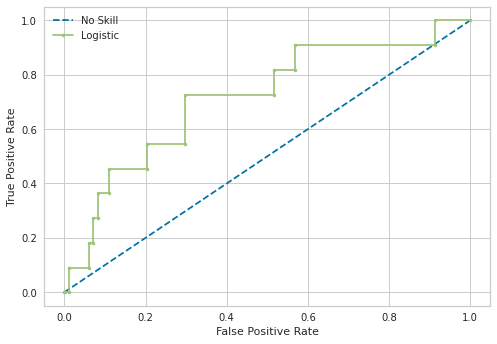

In [102]:
# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

Running the example suggests that the model has skill. Indeed, it has skill, but `all of that skill is measured as making correct true negative predictions and there are a lot of negative predictions to make`. If you review the predictions, you will see that the model predicts the majority class (class 0) in all cases on the test set. **The score is very misleading**.

We can also repeat the test of the same model on the same dataset and calculate a **precision-recall curve** and statistics instead. The complete example is listed below.

Logistic: f1=0.000 auc=0.054


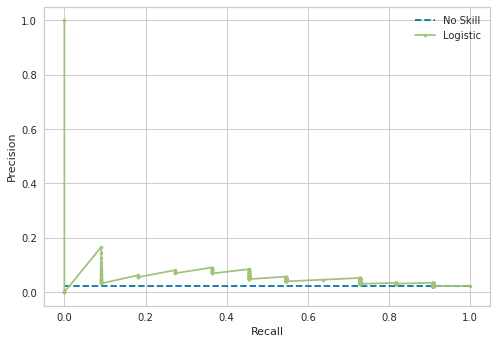

In [103]:
# precision-recall curve and f1 for an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
yhat = model.predict(testX)

# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)

# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

We can see that the model is penalized for predicting the majority class in all cases. The scores show that the model that looked good according to the ROC Curve is in fact barely skillful when considered using precision and recall that focus on the positive class.

The plot of the precision-recall curve highlights that the model is just barely above the no skill line for most thresholds. This is possible because the model predicts probabilities and is uncertain about some cases. These get exposed through the different thresholds evaluated in the construction of the curve, flipping some class 0 to class 1, offering some precision but very low recall.

---
<a id='gain'></a>

## Cumulative Gains Plot
A **cumulative gains plot** can be used `to evaluate a binary classifier`. It models the `true positive rate (sensitivity)` against the `support rate (fraction of positive predictions)`. The intuition behind this plot is to sort all classifications by predicted probability. Ideally there would be a clean cut that divides positive from negative samples. If the first 10% of the predictions has 30% of the positive samples, you would plot a point from (0,0) to (.1, .3). You continue this process through all of the samples.

`A common use for this is determining customer response`. The cumulative gains curve plots the support or predicted positive rate along the x-axis. Our chart labels this as `"Percentage of sample"`. It plots the sensitivity or true positive rate along the y-axis. This is labeled as `"Gain"` in our plot.

**If you wanted to contact 90% of the customers that would respond (sensitivity), you can trace from .9 on the y-axis to the right until you hit that curve. The x-axis at that point will indicate how many total customers you need to contact (support) to get to 90%.**

In this case we aren’t contacting customers that would respond to a survey but predicting if someone has diabetes. If we ordered all patients according to our model by how likely they are to have diabetes, if you took the first 60% of them, you would have 90% of the survivors. If you have an associated cost per contact and revenue per response, you can calculate what the best number is.

In general, a model that is to the left and above another model is a better model. The best models are lines that go up to the top (if 10% of the samples are positive, it would hit at (.1, 1)) and then directly to the right. If the plot is below the baseline, we would do better to randomly assign labels that use our model.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


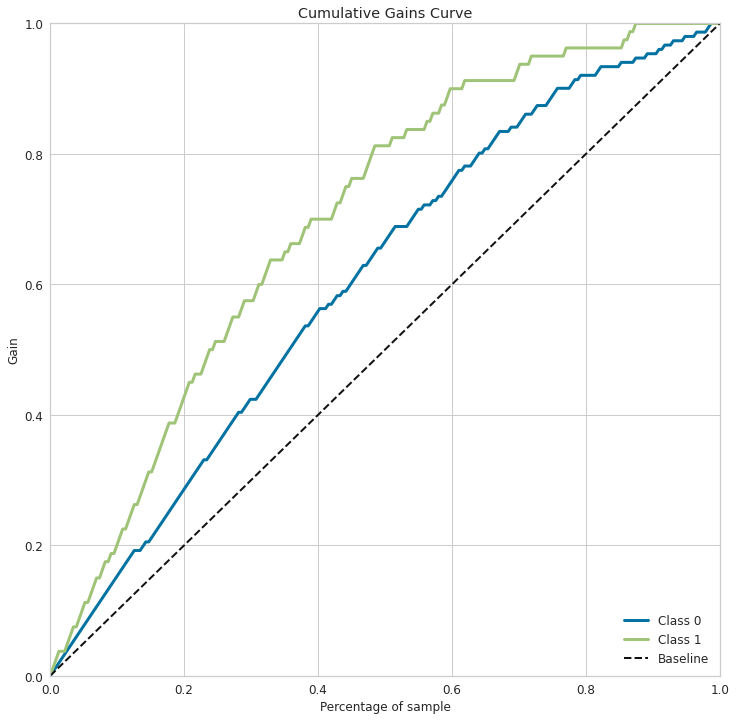

In [29]:
import scikitplot as skplt

fig, ax = plt.subplots(figsize=(12, 12))

y_probas = rfc.predict_proba(X_test)

skplt.metrics.plot_cumulative_gain(
    y_test, 
    y_probas, 
    ax=ax,
)

fig.savefig("images/cumulative_gains_plot.png", dpi=300, bbox_inches="tight",)

---
<a id='lift'></a>

## Lift Curve
A **lift curve** is another way of looking at the information in a cumulative gains plot. The `lift` is how much better we are doing than the baseline model. In our plot below, we can see that if we sorted our Diabetes patients by the has-diabetes probability and took the first 20% of them, our lift would be about 2.2 times (the gain divided by sample percent) better than randomly choosing patients. We would get 2.2 times as many patients.

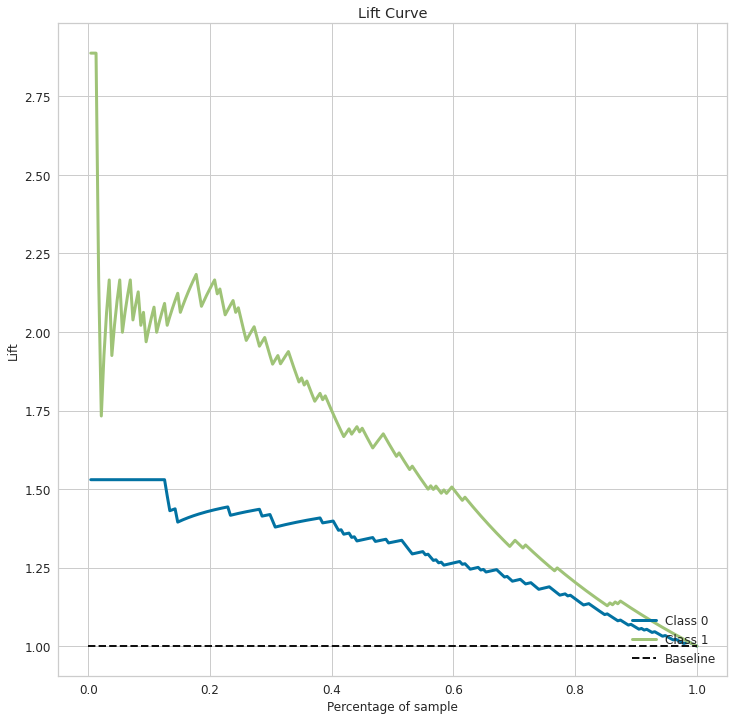

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))

skplt.metrics.plot_lift_curve(
    y_test, 
    y_probas, 
    ax=ax,
)

fig.savefig("images/lift_curve.png", dpi=300, bbox_inches="tight",)

---
<a id='class'></a>

## Class Balance
**When the relative class sizes are different, `accuracy` is not a good evaluation metric.** When splitting up the data into training and test sets, use `stratified sampling` so the sets keep a relative proportion of the classes. The `test_train_split` function does this when you set the `stratify` parameter to the labels.

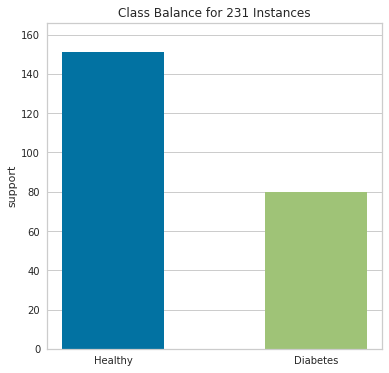

In [31]:
from yellowbrick.classifier import ClassBalance

fig, ax = plt.subplots(figsize=(6, 6))
cb_viz = ClassBalance(labels=["Healthy", "Diabetes"])
cb_viz.fit(y_test.values.reshape(-1, 1).flatten())
cb_viz.poof()
fig.savefig("images/class_balance.png", dpi=300)

In [32]:
y_test

,class
668,0
324,0
624,0
690,0
473,0
...,...
619,1
198,1
538,0
329,0


In [33]:
y_test.values.reshape(-1, 1).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

---
<a id='class_err'></a>

## Class Prediction Error
The **class prediction error plot** from Yellowbrick is a bar chart that visualizes a `confusion matrix`.

In [34]:
y_test_arr = y_test.values.reshape(-1, 1).flatten()
y_test_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


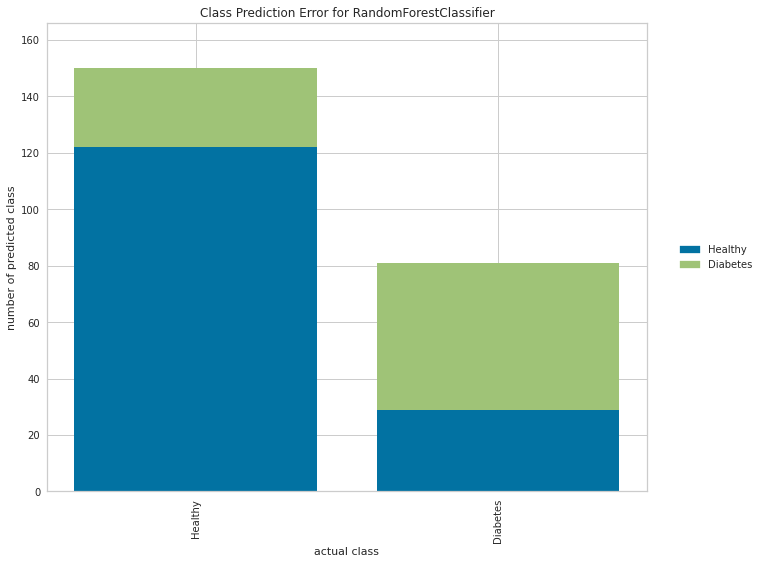

In [35]:
from yellowbrick.classifier import (
    ClassPredictionError,
)

fig, ax = plt.subplots(figsize=(12, 8))
cpe_viz = ClassPredictionError(
    rfc, classes=["Healthy", "Diabetes"]
)
cpe_viz.score(X_test, y_test_arr)
cpe_viz.poof()
fig.savefig("images/class_prediction_error.png", dpi=300)

**Class prediction error:** At the top of the left bar are people who are healthy, but we predicted that they have diabetes (`false positive`). At the bottom of the right bar are people who has diabetes, but the model predicted they are healthy (`false negative`).

---
<a id='threshold'></a>

## Discrimination Threshold
Many machine learning algorithms are capable of predicting a probability or scoring of class membership, and this must be interpreted before it can be mapped to a crisp class label. This is useful generally as it provides a measure of the certainty or uncertainty of a prediction. It also provides additional granularity over just predicting the class label that can be interpreted.

The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the **decision threshold**, **discrimination threshold**, or simply the **threshold**. The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.

For example, on a binary classification problem with class labels 0 and 1, normalized predicted probabilities and a threshold of 0.5, then values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1:

- Prediction < 0.5 = Class 0
- Prediction >= 0.5 = Class 1

The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities. This might be the case for a number of reasons, such as:

- The predicted probabilities are not calibrated, e.g. those predicted by an SVM or decision tree.
- The metric used to train the model is different from the metric used to evaluate a final model.
- The class distribution is severely skewed (imbalanced classification problem).
- The cost of one type of misclassification is more important than another type of misclassification.

Worse still, some or all of these reasons may occur at the same time. In such cases, the default threshold can result in poor performance. As such, **a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold** used to map probabilities to class labels.

In some cases, such as when using ROC Curves and Precision-Recall Curves, the best or optimal threshold for the classifier can be calculated directly. In other cases, it is possible to use a grid search to tune the threshold and locate the optimal value.

---
<a id='threshold_imb'></a>

### Threshold-Moving for Imbalanced Classification

There are many techniques that may be used to address an imbalanced classification problem, such as resampling the training dataset and developing customized version of machine learning algorithms.

Nevertheless, perhaps the simplest approach to handle a severe class imbalance is to change the decision threshold. Although simple and very effective, this technique is often overlooked by practitioners and research academics alike.

You may use: 
- **ROC Curves** to analyze the predicted probabilities of a model and **ROC AUC** scores to compare and select a model, although you require crisp class labels from your model. How do you choose the threshold on the ROC Curve that results in the best balance between the true positive rate and the false positive rate?
- **Precision-Recall Curves** to analyze the predicted probabilities of a model, **Precision-Recall AUC** to compare and select models, and require crisp class labels as predictions. How do you choose the threshold on the Precision-Recall Curve that results in the best balance between precision and recall?
- a probability-based metric to train, evaluate, and compare models like **log loss (cross-entropy)** but require crisp class labels to be predicted. How do you choose the optimal threshold from predicted probabilities more generally?
- have different costs associated with false positive and false negative misclassification, a so-called **cost matrix**, but wish to use and evaluate cost-insensitive models and later evaluate their predictions use a cost-sensitive measure. How do you choose a threshold that finds the best trade-off for predictions using the cost matrix?

The answer to these questions is to search a range of threshold values in order to find the best threshold. In some cases, the optimal threshold can be calculated directly. Tuning or shifting the decision threshold in order to accommodate the broader requirements of the classification problem is generally referred to as **threshold-moving**, **threshold-tuning**, or simply **thresholding**.

**Trying other methods, such as `sampling`, without trying by simply setting the threshold may be misleading**. `The threshold-moving method uses the original training set to train a model and then moves the decision threshold such that the minority class examples are easier to be predicted correctly.`

trying other methods, such as sampling, without trying by simply setting the threshold may be misleading. The threshold-moving method uses the original training set to train a model] and then moves the decision threshold such that the minority class examples are easier to be predicted correctly.

The process involves first fitting the model on a training dataset and making predictions on a test dataset. The predictions are in the form of normalized probabilities or scores that are transformed into normalized probabilities. Different threshold values are then tried and the resulting crisp labels are evaluated using a chosen evaluation metric. The threshold that achieves the best evaluation metric is then adopted for the model when making predictions on new data in the future.

We can summarize this procedure below.

1. Fit Model on the Training Dataset.
2. Predict Probabilities on the Test Dataset.
3. For each threshold in Thresholds:
    1. Convert probabilities to Class Labels using the threshold.
    1. Evaluate Class Labels.
    1. If Score is Better than Best Score.
        1. Adopt Threshold.
4. Use Adopted Threshold When Making Class Predictions on New Data.

Although simple, `there are a few different approaches to implementing threshold-moving` depending on your circumstance. We will take a look at some of the most common examples in the following sections.

---
<a id='threshold_roc'></a>

### Optimal Threshold for ROC Curve

A **ROC curve** is a diagnostic plot that evaluates a set of probability predictions made by a model on a test dataset. A set of different thresholds are used to interpret the true positive rate and the false positive rate of the predictions on the positive (minority) class, and the scores are plotted in a line of increasing thresholds to create a curve.

The curve is useful to understand the trade-off in the true-positive rate and false-positive rate for different thresholds. The area under the ROC Curve, so-called ROC AUC, provides a single number to summarize the performance of a model in terms of its ROC Curve with a value between 0.5 (no-skill) and 1.0 (perfect skill).

If crisp class labels are required from a model under such an analysis, then **an optimal threshold** is required. This would be `a threshold on the curve that is closest to the top-left of the plot`.

#### Geometric Mean
There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates. The **Geometric Mean** or **G-Mean** is a metric for imbalanced classification that, if optimized, will seek a balance between the `sensitivity/recall/TPR` and the `specificity`.

```
Sensitivity = TruePositive / (TruePositive + FalseNegative)
Sensitivity = True Positive Rate

Specificity = TrueNegative / (FalsePositive + TrueNegative)
Specificity = 1 – False Positive Rate

G-Mean = sqrt(Sensitivity * Specificity)
```
One approach would be to test the model with each threshold returned from the call [roc_auc_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) and select the threshold with the largest G-Mean value.

Given that we have already calculated the Sensitivity (TPR) and the complement to the Specificity when we calculated the ROC Curve, we can calculate the G-Mean for each threshold directly. Once calculated, we can locate the index for the largest G-mean score and use that index to determine which threshold value to use.

The threshold is then used to locate the true and false positive rates, then this point is drawn on the ROC Curve.

If we required crisp class labels from this model, which threshold would achieve the best result? We can see that the point for the optimal threshold is a large black dot and it appears to be closest to the top-left of the plot.

Best Threshold=0.016153, G-Mean=0.933


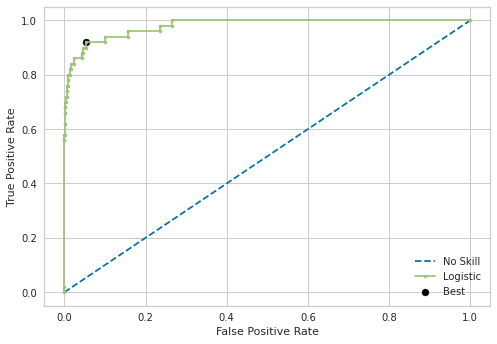

In [108]:
# ROC Curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

#### Youden's J statistic
It turns out there is a much faster way to get the same result, called the [Youden’s J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic).

The statistic is calculated as:
```
J = Sensitivity + Specificity – 1
```
Given that we have Sensitivity (TPR) and the complement of the specificity (FPR), we can calculate it as:
```
J = Sensitivity + (1 – FalsePositiveRate) – 1
```
Which we can restate as:
```
J = TruePositiveRate – FalsePositiveRate
```
We can then choose the threshold with the largest J statistic value.

Best Threshold=0.016153


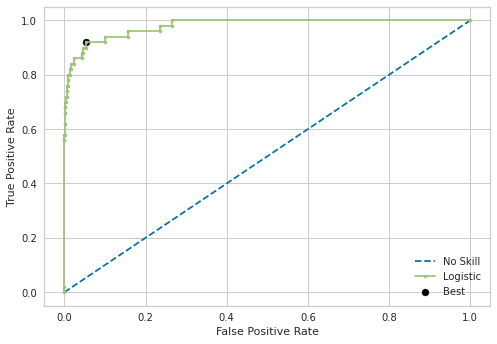

In [109]:
# ROC Curve for logistic regression model with optimal threshold
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

This threshold could then be used when making probability predictions in the future that must be converted from probabilities to crisp class labels.
```
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 2)
clf.fit(X_train,y_train)

# default threshold is 0.5
# y_pred = clf.predict(X_test)  

# set threshold as 0.3
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) 
```

---
<a id='threshold_prc'></a>

### Optimal Threshold for Precision-Recall Curve
Unlike the ROC Curve, a **Precision-Recall Curve** focuses on the performance of a classifier on the positive (minority class) only.

`Precision` is the ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. `Recall` is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

A **Precision-Recall Curve** is calculated by creating crisp class labels for probability predictions across a set of thresholds and calculating the precision and recall for each threshold. A line plot is created for the thresholds in ascending order with recall on the x-axis and precision on the y-axis.

A `no-skill model` is represented by a horizontal line with a precision that is the ratio of positive examples in the dataset (e.g. TP / (TP + TN)), or 0.01 on our synthetic dataset. `Perfect skill classifier` has full precision and recall with a dot in the top-right corner.

We can use the same model and dataset from the previous section and evaluate the probability predictions for a logistic regression model using a precision-recall curve. The [precision_recall_curve()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function can be used to calculate the curve, returning the precision and recall scores for each threshold as well as the thresholds used.

Running the example below calculates the precision and recall for each threshold and creates a precision-recall plot showing that the model has some skill across a range of thresholds on this dataset. If we required crisp class labels from this model, which threshold would achieve the best result?

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the **F-measure** that summarizes the harmonic mean of both measures.
```
F-Measure = (2 * Precision * Recall) / (Precision + Recall)
```
As in the previous section, the naive approach to finding the optimal threshold would be to calculate the F-measure for each threshold. We can achieve the same effect by converting the precision and recall measures to F-measure directly.
```
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
```
We can then plot the point on the precision-recall curve.

Best Threshold=0.256036, F-Score=0.756


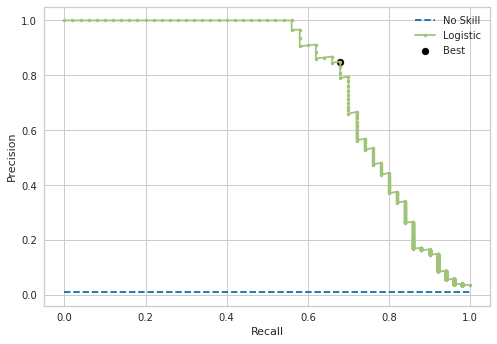

In [112]:
# PR Curve for logistic regression model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

The precision-recall curve is plotted, and this time the threshold with the optimal F-measure is plotted with a larger black dot.

This threshold could then be used when making probability predictions in the future that must be converted from probabilities to crisp class labels.
```
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 2)
clf.fit(X_train,y_train)

# default threshold is 0.5
# y_pred = clf.predict(X_test)  

# set threshold as 0.3
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) 
```

---
<a id='threshold_tune'></a>

### Optimal Threshold Tuning
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

---
<a id='threshold_plot'></a>

### Discrimination Thershold Plot

The **discrimination threshold plot** moves that threshold value between 0 and 100 and shows the impact to `precision`, `recall`, `f1`, and `queue rate`.

This plot can be useful to view the `trade-off between precision and recall`. Assume we are looking for fraud (and considering fraud to be the positive classification). To get high `recall` (catch all of the fraud), we can just classify everything as fraud. But in a bank situation, this would not be profitable and would require an army of workers. To get high `precision` (only catch fraud if it is fraud), we could have a model that only triggers on cases of extreme fraud. But this would miss much of the fraud that might not be as obvious. There is a trade-off here.

The `queue rate` is the percent of predictions above the threshold. You can consider this to be the percent of cases to review if you are dealing with fraud.

If you have the cost for positive, negative, and erroneous calculations, you can determine what threshold you are comfortable with.

The following plot is useful to see what `discrimination threshold` will maximize the `f1` score or adjust `precision` or `recall` to an acceptable number when coupled with the queue rate.

Yellowbrick provides this visualizer. This visualizer shuffles the data and runs 50 trials by default, splitting out 10% for validation.

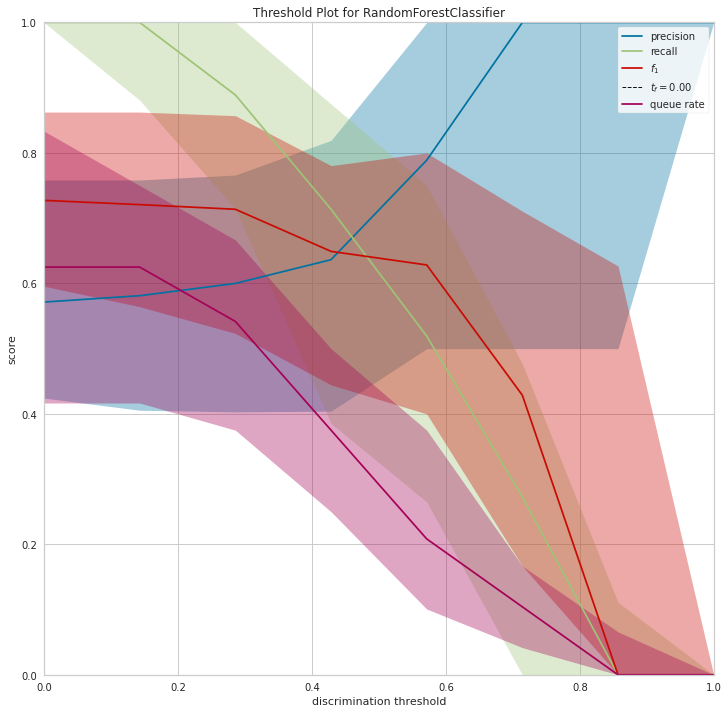

In [106]:
from yellowbrick.classifier import (
    DiscriminationThreshold,
)

y_test_arr = y_test.values

fig, ax = plt.subplots(figsize=(12, 12))
dt_viz = DiscriminationThreshold(rfc)
dt_viz.fit(X_test, y_test_arr)
dt_viz.poof()
fig.savefig("images/discrimination_thershold.png", dpi=300)